Pontificia Universidad Católica de Chile <br>
Departamento de Ciencia de la Computación <br>
IIC3641 - Aprendizaje Automático Basado en Grafos <br>
Segundo Semestre 2025<br>


<h1><center> Tarea 1: Modelos de grafos  </center></h1>
        Profesor: Marcelo Mendoza<br>
        Fecha de entrega: 8 de septiembre

---

## Indicaciones

Se debe entregar **SOLO** el archivo .ipynb en el buzón respectivo en canvas.

**IMPORTANTE**:
- Se asignará puntaje por el código implementado y los comentarios asociados a resultados.
- El notebook debe tener todas las celdas de código ejecutadas.
- Cualquier instancia de copia resultará en un 1,1 como nota de curso.
- Esta tarea **NO** requiere el uso de GPU.

---

# Integrantes del grupo

* Estudiante 1: Vittorio Salvatore | 216397910

# Librerías

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import networkx as nx

# Importa aquí las librerías que vayas a utilizar
from scipy import stats
import leidenalg as la
import igraph as ig
import time

import cdlib

# Parte 1: Análisis red de colaboración (20 puntos)

En esta sección se debe desarrollar un análisis descriptivo con las principales características asociadas a las siguietes redes:
* **General Relativity and Quantum Cosmology collaboration network:** ca-GrQc.txt
* **Erdös Number:** Erdos982.txt

Suponga que las redes son no dirigidas.

## 1.1 Medidas básicas (10 puntos)


Grafique las redes de colaboraciones y determine las siguientes medidas descriptivas para cada caso si se puede:

* Número de nodos
* Número de componentes
* Número de aristas
* Grado promedio
* Diametro
* Camino mínimo promedio

¿Qué características diferencian a estas redes? Interprete sus resultados en el contexto del problema.

**Observación**

En caso de reconocer dos o más componentes asociados a una red, solo trabaje con la de mayor tamaño .


**Respuesta:**

In [15]:
# eros 
# ca_y el otro, no asia edges

collaboration_network = nx.read_edgelist(
    path='/Users/vittoriosalvatore/local_desk/Universidad/aprendizaje_en_grafos/Tarea_1/ca-GrQc.txt',
    delimiter = '\t',
)

erdos = nx.read_edgelist(
    path='/Users/vittoriosalvatore/local_desk/Universidad/aprendizaje_en_grafos/Tarea_1/Erdos982.txt',
    delimiter=' '
)

In [64]:
def plot_graph(G, title="Graph", node_size=50, labels=False):

    node_degrees = dict(G.degree())
    degrees = np.array(list(node_degrees.values()))
    vmin, vmax = degrees.min(), degrees.max()

    pos = nx.spring_layout(G, seed=42)

    fig, ax = plt.subplots(figsize=(6, 6))

    normalized_degrees = (degrees - vmin) / (vmax - vmin)


    nodes = nx.draw_networkx_nodes(
        G, pos,
        node_color=normalized_degrees,
        cmap=plt.cm.coolwarm,
        vmin=min(normalized_degrees), vmax=max(normalized_degrees),
        node_size=node_size,
        ax=ax
    )
    nx.draw_networkx_edges(G, pos, edge_color='gray', ax=ax)

    if labels:
        nx.draw_networkx_labels(G, pos, ax=ax)

    cbar = fig.colorbar(nodes, ax=ax)
    cbar.set_label("Grado del Nodo")

    ax.set_title(title)
    ax.axis('off')
    plt.tight_layout()
    plt.show()


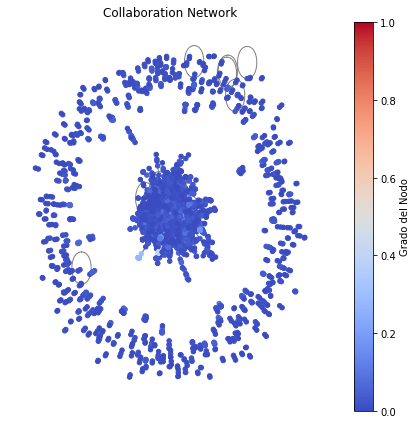

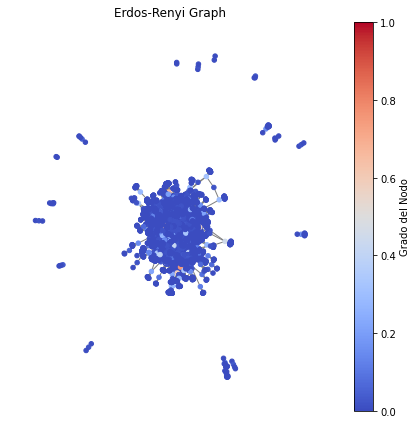

In [65]:
plot_graph(collaboration_network, title="Collaboration Network", node_size=20)
plot_graph(erdos, title="Erdos-Renyi Graph", node_size=20)

In [25]:
l = [collaboration_network, erdos]
names = ['Collaboration Network', 'Erdos']

for g, name in zip(l, names):
    print('------------------')
    print('Estadisticas del grafo', name)
    print('------------------')
    print('Numero de nodos:', g.number_of_nodes())
    print('Numero de edges:', g.number_of_edges())
    print('Número de componentes conexas:', nx.number_connected_components(g))
    print('Grado promedio:', np.mean([d for n, d in g.degree()]))

    componente_mas_grande = g.subgraph(max(nx.connected_components(g), key=len))

    print('Diámetro (de la componente más grande):', nx.diameter(componente_mas_grande, usebounds=True))
    print('Camino minimo promeedio (en la componente más grande):', nx.average_shortest_path_length(componente_mas_grande))
    print()

------------------
Estadisticas del grafo Collaboration Network
------------------
Numero de nodos: 5244
Numero de edges: 14497
Número de componentes conexas: 356
Grado promedio: 5.528985507246377
Diámetro (de la componente más grande): 17
Camino minimo promeedio (en la componente más grande): 6.049380016182999

------------------
Estadisticas del grafo Erdos
------------------
Numero de nodos: 4964
Numero de edges: 7376
Número de componentes conexas: 18
Grado promedio: 2.9717969379532634
Diámetro (de la componente más grande): 13
Camino minimo promeedio (en la componente más grande): 5.466510105952043



Hay un gran número de diferencias entre ambos grafos a partír de las estadisticas. La primera estadistica que sobresala es la relación entre el número de nodos y el número de aristas, con el grafo Erdos estando considerablemente más conectado. Collaboration Network es mucho más disconexo que el grafo Erdos, tiene un grado promedio más alto, y un mayor diametro en la componente más grande.

A fin de cuentas, las estadisticas y las diferencias entre ambos grafos se pueden entender mejor viendolos desde los graficos. El grafo Erdos es compacto, muchos nodos y conexiones muy similares, no particularmente disconexo, mientras que el collaboration network tiene nodos con distintas cantidades de aristas y estrucutras, menos compacto y más alejados entre si, de una manera más robusta que el grafo Erdos. Esto es decir, que la forma en que las citas funcionan en este sistema de papers se da para que existan comunidades, papers (y autores) más alejados unos de otros, papers que funcionan de hubs para distintas áreas, y que no se puede pensar como que cada papar tenga una probabilidad p arbitraría de conectarse con cualquier otro paper o autor.

## 1.2 Evaluación de nodos (5 puntos)

Investigue y describa las siguientes métricas:

* degree centrality
* closeness centrality
* betweenness centrality

¿En qué se diferencian?

Calcule las métricas para cada red y grafique su distribución. Comente.

Para cada caso, ¿qué nodos son los más relevantes según el criterio de centralidad?

**Respuesta:**

Las tres son métricas que buscan medir medir que tan central, o importante, es un nodo en particular dentro de un grafo. Cada métrica mide una manera en que un nodo se puede considerar imporante.

1. Degree centrality:

    La idea detrás es que un nodo es central en un grafo si hay muchos otros nodos conectado a este, es decir, que el nodo más importante es aquel con más conexiones. Para un nodo *v*, la formula normalizada tiene la forma

    $$
    C_{v} = \frac{deg(v)}{n-1}
    $$

2. Closeness centrality

    La idea destrás es que un nodo se puede llamar central y/o importante si es que está más cercano a los demás nodos del grafo. Para esto, se incorpora el largo promedio del camino más corto a los demás nodos. La formula es

    $$
    C_{v} = \frac{n-1}{\sum_{u} d(v,u)}
    $$

3. Betweenness centrality:

    La idea es que un nodo se puede llamar más central y/o importante mientras más se encuentre en el camino entre los demás nodos, es decir, que tanto actua como "puente" o "broker". Para esto, se mide que tanto paprticipa en el shortest path entre otros pares de nodos. La formula es

    $$
    C_{v} = \sum_{s \neq v \neq t \in V}\frac{\sigma_{st(v)}}{\sigma_{st}}
    $$

    Con $\sigma_{st}$ el número de shortest paths desde s a t y $\sigma_{st}(v)$ el número de aquellos que pasan por el nodo $v \in V$

In [27]:

deg_centrality_collab = nx.degree_centrality(collaboration_network)
deg_centrality_erdos = nx.degree_centrality(erdos)

closeness_centrality_collab = nx.closeness_centrality(collaboration_network)
closeness_centrality_erdos = nx.closeness_centrality(erdos)

betweenness_centrality_collab = nx.betweenness_centrality(collaboration_network)
betweenness_centrality_erdos = nx.betweenness_centrality(erdos)

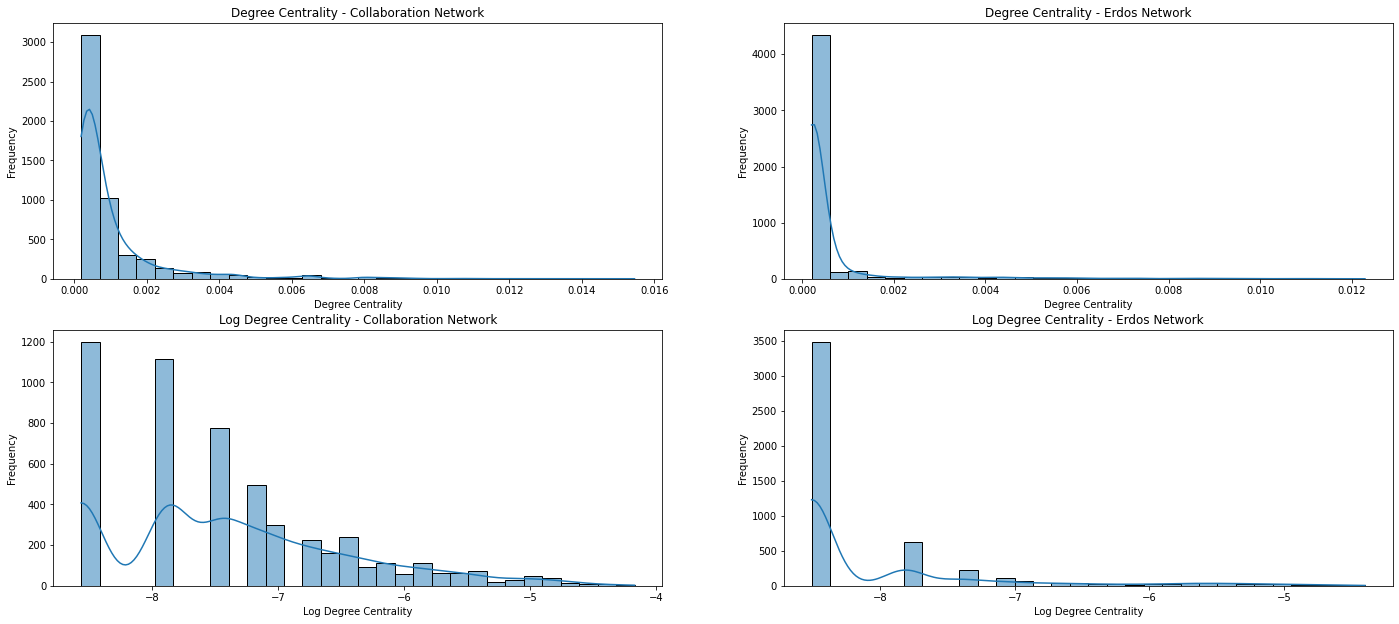

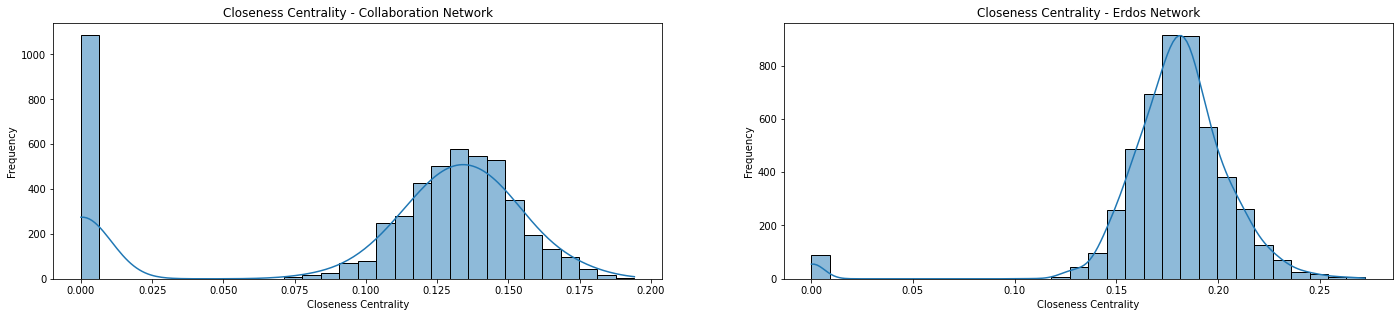

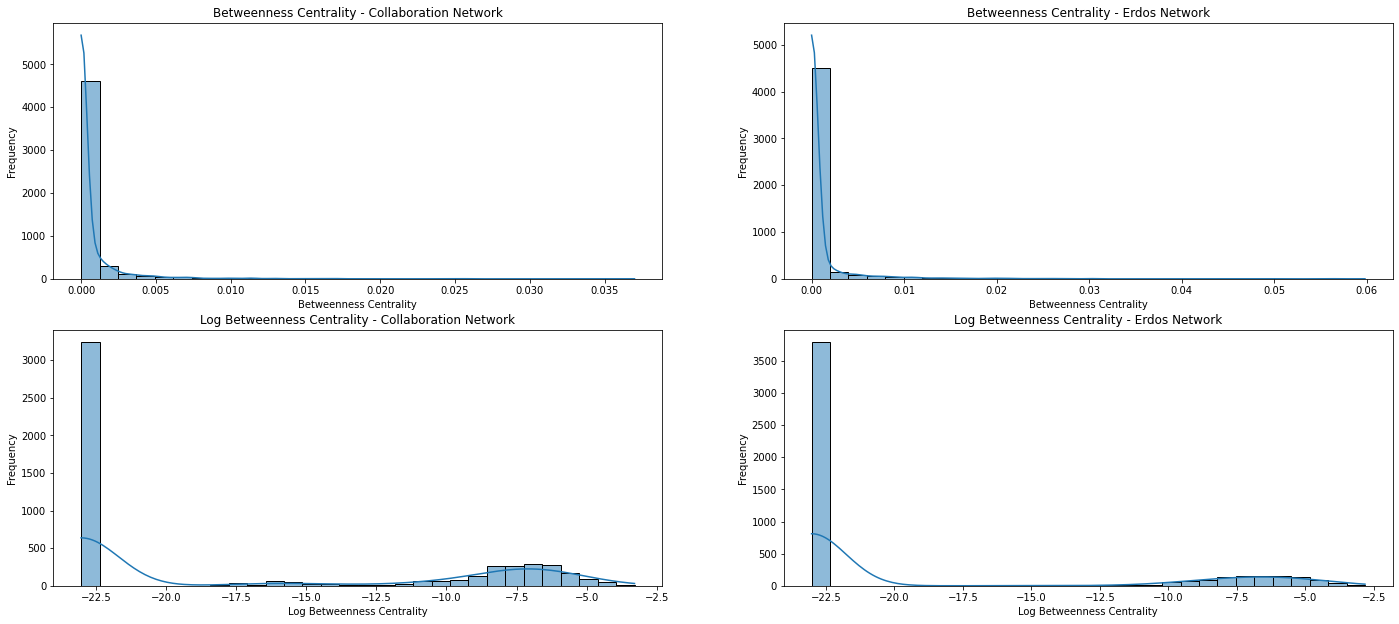

In [41]:
log_deg_centrality_collab = {k: np.log(v + 1e-10) for k, v in deg_centrality_collab.items()}
log_deg_centrality_erdos = {k: np.log(v + 1e-10) for k, v in deg_centrality_erdos.items()}

plt.figure(figsize=(24, 16))
plt.subplot(3, 2, 1)
sns.histplot(list(deg_centrality_collab.values()), bins=30, kde=True)
plt.title('Degree Centrality - Collaboration Network')
plt.xlabel('Degree Centrality')
plt.ylabel('Frequency')

plt.subplot(3, 2, 2)
sns.histplot(list(deg_centrality_erdos.values()), bins=30, kde=True)
plt.title('Degree Centrality - Erdos Network')
plt.xlabel('Degree Centrality')
plt.ylabel('Frequency')

plt.subplot(3, 2, 3)
sns.histplot(list(log_deg_centrality_collab.values()), bins=30, kde=True)
plt.title('Log Degree Centrality - Collaboration Network')
plt.xlabel('Log Degree Centrality')
plt.ylabel('Frequency')

plt.subplot(3, 2, 4)
sns.histplot(list(log_deg_centrality_erdos.values()), bins=30, kde=True)
plt.title('Log Degree Centrality - Erdos Network')
plt.xlabel('Log Degree Centrality')
plt.ylabel('Frequency')

plt.figure(figsize=(24, 16))
plt.subplot(3, 2, 1)
sns.histplot(list(closeness_centrality_collab.values()), bins=30, kde=True)
plt.title('Closeness Centrality - Collaboration Network')
plt.xlabel('Closeness Centrality')
plt.ylabel('Frequency')
plt.subplot(3, 2, 2)
sns.histplot(list(closeness_centrality_erdos.values()), bins=30, kde=True)
plt.title('Closeness Centrality - Erdos Network')
plt.xlabel('Closeness Centrality')
plt.ylabel('Frequency')

log_betweenness_centrality_collab = {k: np.log(v + 1e-10) for k, v in betweenness_centrality_collab.items()}
log_betweenness_centrality_erdos = {k: np.log(v + 1e-10) for k, v in betweenness_centrality_erdos.items()}

plt.figure(figsize=(24, 16))
plt.subplot(3, 2, 1)
sns.histplot(list(betweenness_centrality_collab.values()), bins=10, kde=True)
plt.title('Betweenness Centrality - Collaboration Network')
plt.xlabel('Betweenness Centrality')
plt.ylabel('Frequency')
plt.subplot(3, 2, 2)
sns.histplot(list(betweenness_centrality_erdos.values()), bins=10, kde=True)
plt.title('Betweenness Centrality - Erdos Network')
plt.xlabel('Betweenness Centrality')
plt.ylabel('Frequency')
plt.subplot(3, 2, 3)
sns.histplot(list(log_betweenness_centrality_collab.values()), bins=10, kde=True)
plt.title('Log Betweenness Centrality - Collaboration Network')
plt.xlabel('Log Betweenness Centrality')
plt.ylabel('Frequency')
plt.subplot(3, 2, 4)
sns.histplot(list(log_betweenness_centrality_erdos.values()), bins=10, kde=True)
plt.title('Log Betweenness Centrality - Erdos Network')
plt.xlabel('Log Betweenness Centrality')
plt.ylabel('Frequency')
plt.show()

A partir de los graficos generados de las distintas métricas de centralidad se puede observar un comportamiento muy distinto entre la red de los datos y el grafo erdos. Para comenzar, el degree centrality del grafo de collaboration network muestra varios nodos con diversos números de combinaciones, demostrando robustes en el grafo, mientras que en el modelo Erdos, casi todos los nodos tienen cerca del mismo número de aristas, resultado producto del método de creación del grafo aleatorio.

Por otra parte, en el grafico de closeness centrality se observa que en la collaboration network hay una mayor frecuencia de nodos "alejados" de los demás que en el grafo Erdos. Esto es porque el denominador, la suma de los shortest paths, es muy grande para un mayor número de nodos. Además, el grafo Erdos se encuentra bastante más concentrado en una media, mostrando que la mayoría de los nodos se encuentran relativamente cerca los unos a los otros.

A primera vista, ambos grafos tienen comportamiento relativamente similar en el betweeneess centrality, es decir, que a grandes rasgos, hay un gran número de elementos que son puentes para pocos nodos. Esto puede ser porque muchos papers que no actuan como links entre otros, y la atención se va hacia hubs. Sin embargo, es importante destacar que hay un mayor número de hubds en el collaboration network, y con mayor varianza en el espacio en donde están concentrados. Además, algo que no sucede en el modelo Erdos, es que hay unos pocos "hubs intermedios", que conectan algunos shortest paths entre papers.

In [43]:
# Buscamos los nodos más centrales según cada métrica

top_10_deg_collab = sorted(deg_centrality_collab.items(), key=lambda x: x[1], reverse=True)[:10]
top_10_deg_erdos = sorted(deg_centrality_erdos.items(), key=lambda x: x[1], reverse=True)[:10]

print("Top 10 Degree Centrality - Collaboration Network:", top_10_deg_collab)
print("Top 10 Degree Centrality - Erdos Network:", top_10_deg_erdos)

top_10_closeness_collab = sorted(closeness_centrality_collab.items(), key=lambda x: x[1], reverse=True)[:10]
top_10_closeness_erdos = sorted(closeness_centrality_erdos.items(), key=lambda x: x[1], reverse=True)[:10]

print("Top 10 Closeness Centrality - Collaboration Network:", top_10_closeness_collab)
print("Top 10 Closeness Centrality - Erdos Network:", top_10_closeness_erdos)

top_10_betweenness_collab = sorted(betweenness_centrality_collab.items(), key=lambda x: x[1], reverse=True)[:10]
top_10_betweenness_erdos = sorted(betweenness_centrality_erdos.items(), key=lambda x: x[1], reverse=True)[:10]

print("Top 10 Betweenness Centrality - Collaboration Network:", top_10_betweenness_collab)
print("Top 10 Betweenness Centrality - Erdos Network:", top_10_betweenness_erdos)

Top 10 Degree Centrality - Collaboration Network: [('21012', 0.015449170322334543), ('21281', 0.015067709326721343), ('22691', 0.014686248331108145), ('12365', 0.014686248331108145), ('6610', 0.012969673850848752), ('9785', 0.012969673850848752), ('21508', 0.012778943353042152), ('17655', 0.012588212855235552), ('2741', 0.012397482357428954), ('19423', 0.012016021361815754)]
Top 10 Degree Centrality - Erdos Network: [('426', 0.01229095305258916), ('438', 0.012089462018940157), ('244', 0.011686479951642152), ('339', 0.011686479951642152), ('310', 0.011082006850695145), ('320', 0.011082006850695145), ('383', 0.011082006850695145), ('195', 0.010880515817046141), ('191', 0.010880515817046141), ('417', 0.01067902478339714)]
Top 10 Closeness Centrality - Collaboration Network: [('13801', 0.1942105230211014), ('14485', 0.18946578444418902), ('9572', 0.18896610401279165), ('17655', 0.18889029664686297), ('2654', 0.18705713883036956), ('21012', 0.18647506569680972), ('12545', 0.1859175759358704

## 1.3 Eliminación de nodos (5 puntos)

Tomando en consideración el criterio de centralidad de los nodos, elimine los 10 más relevantes para cada caso. Justifique su decisión.

Luego, grafique las nuevas redes obtenidas y calcule las métricas de la actividad 1.1. Comente.

¿Qué red muestra mayor robustez? Justifique su respuesta.

**Respuesta:**

Se eliminan los 10 nodos más relevantes, es decir, los con mayor centralidad, según cada métrica para cada gráfico. A pesar de que cada nodo relevante para alguna métrica es imporante, lo son por distintas razones, y así removerlos trae distintas consecuencias en el grafo resultante. Se decidió operar de esta manera para poder observar todos los efectos de considerar una métrica sobre las demás.

In [44]:
# Parte 1: Quitar los 10 nodos más centrales según degree centrality.

l = [collaboration_network, erdos]
s = [top_10_deg_collab, top_10_deg_erdos,
     top_10_closeness_collab, top_10_closeness_erdos,
     top_10_betweenness_collab, top_10_betweenness_erdos]
names = ['Collaboration Network', 'Erdos']

for i in range(6):
    
    indx = i % 2

    print('------------------')
    print('Estadisticas del grafo', names[indx], 'retirando según la métrica',
          'Degree Centrality' if i < 2 else ('Closeness Centrality' if i < 4 else 'Betweenness Centrality'))
    print('------------------')

    g = l[indx].copy()
    top_10_node_ids = [node for node, centrality in s[i]]
    g.remove_nodes_from(top_10_node_ids)

    print('Numero de nodos:', g.number_of_nodes())
    print('Numero de edges:', g.number_of_edges())
    print('Número de componentes conexas:', nx.number_connected_components(g))
    print('Grado promedio:', np.mean([d for n, d in g.degree()]))

    componente_mas_grande = g.subgraph(max(nx.connected_components(g), key=len))

    print('Diámetro (de la componente más grande):', nx.diameter(componente_mas_grande, usebounds=True))
    print('Camino minimo promeedio (en la componente más grande):', nx.average_shortest_path_length(componente_mas_grande))
    print()

------------------
Estadisticas del grafo Collaboration Network retirando según la métrica Degree Centrality
------------------
Numero de nodos: 5234
Numero de edges: 13831
Número de componentes conexas: 363
Grado promedio: 5.285059228123806
Diámetro (de la componente más grande): 17
Camino minimo promeedio (en la componente más grande): 6.122920704378588

------------------
Estadisticas del grafo Erdos retirando según la métrica Degree Centrality
------------------
Numero de nodos: 4954
Numero de edges: 6817
Número de componentes conexas: 203
Grado promedio: 2.752119499394429
Diámetro (de la componente más grande): 14
Camino minimo promeedio (en la componente más grande): 5.709004342559374

------------------
Estadisticas del grafo Collaboration Network retirando según la métrica Closeness Centrality
------------------
Numero de nodos: 5234
Numero de edges: 14026
Número de componentes conexas: 371
Grado promedio: 5.359572029040886
Diámetro (de la componente más grande): 17
Camino mini

<Figure size 2304x2304 with 0 Axes>

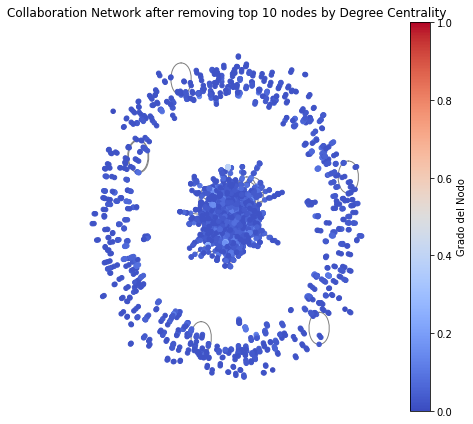

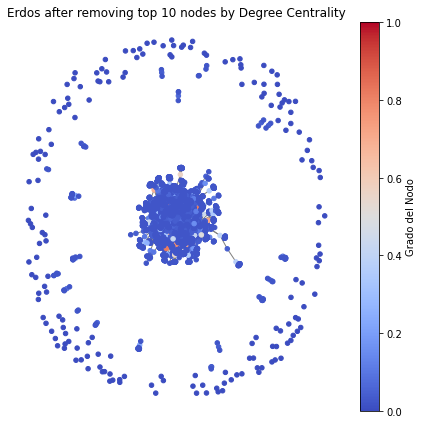

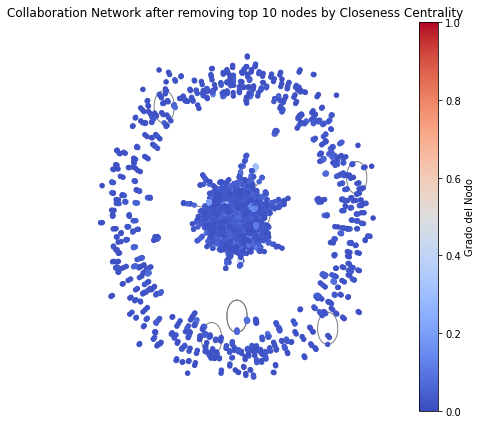

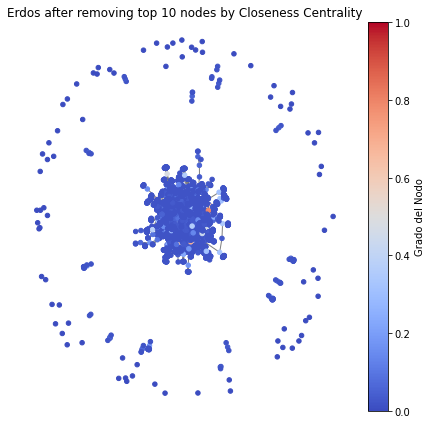

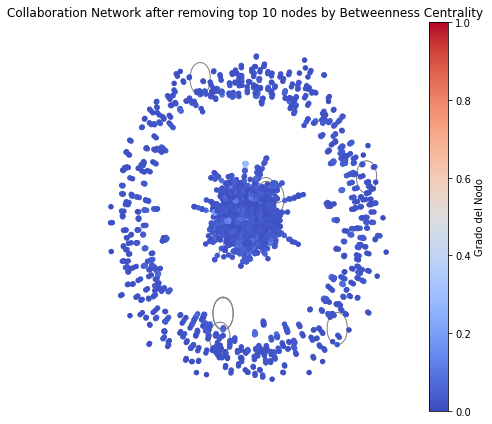

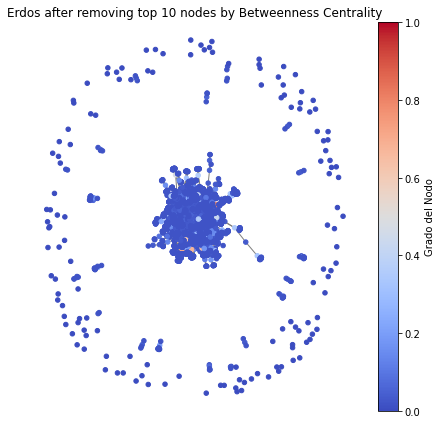

In [66]:
# Grafos 

plt.figure(figsize=(32, 32))

for i in range(6):

    indx = i % 2

    g = l[indx].copy()
    top_10_node_ids = [node for node, centrality in s[i]]
    g.remove_nodes_from(top_10_node_ids)

    plot_graph(g, title=f"{names[indx]} after removing top 10 nodes by " +
               ('Degree Centrality' if i < 2 else ('Closeness Centrality' if i < 4 else 'Betweenness Centrality')), node_size=20)

| Grafo                                               | Nodos | Edges | Componentes conexas | Grado promedio | Diámetro (mayor comp.) | Camino mínimo promedio (mayor comp.) |
|-----------------------------------------------------|-------|-------|----------------------|----------------|------------------------|---------------------------------------|
| Collaboration Network                               | 5244  | 14497 | 356                  | 5.529          | 17                     | 6.049                                 |
| Erdos                                               | 4964  | 7376  | 18                   | 2.972          | 13                     | 5.467                                 |
| Collaboration Network (Degree Centrality)           | 5234  | 13831 | 363                  | 5.285          | 17                     | 6.123                                 |
| Erdos (Degree Centrality)                           | 4954  | 6817  | 203                  | 2.752          | 14                     | 5.709                                 |
| Collaboration Network (Closeness Centrality)        | 5234  | 14026 | 371                  | 5.360          | 17                     | 6.197                                 |
| Erdos (Closeness Centrality)                        | 4954  | 6930  | 99                   | 2.798          | 14                     | 5.707                                 |
| Collaboration Network (Betweenness Centrality)      | 5234  | 14130 | 390                  | 5.399          | 17                     | 6.302                                 |
| Erdos (Betweenness Centrality)                      | 4954  | 6886  | 160                  | 2.780          | 15                     | 5.778                                 |


A partir de los cambios, se observa que al retirar nodos según degree centrality, se retiraron nodos con muchas conexiones, y así, bajó el número de edges. Se observa que el modelo que cambió más producto de retirar estos nodos fue el grafo Erdos. Lo que se nota muy bien en como pasó de 18 a 203 componentes conexas, puesto que los nodos con varias conexiones (infrecuentes por la probabilidad con que fue creado el modelo) eran precisamente los que conectaban el grafo.

Luego, al eliminar los nodos más relevantes por closeness centrality, en teoría deberían eliminarse aquellos valores que estan en promedio a menor distancia de los nodos del grafo, pero en esta estructura en particular, no pareció afectar en gran manera al collaboration network, especialmente al camino minimo promedio,, posiblemente dado a que hay bastantes nodos lejanos que disminuyen el peso de quitar estos nodos, y por la estrucutra misma del grafo. Por otra parte, esta métrica afectó bastante más al grafo Erdos, muy posiblemente por la razón ya mencionada en el parrafo anterior.

Finalmente, al eliminar nodos según betweenness centrality, en teoría se están eliminando los nodos que actuan como "brokers" o "puentes". Entre todos los trials, está fue la medida que más afecto a la collaboration network en las componentes conexas, por claros motivos, aunque no disminuyó el grado promedio tanto como las demás, si logró aumentar el camino mínimo promedio bastante. Por otra parte, el grafo Erdos no tuvo tantas componentes conexas como las pruebas con Degree centrality (aunque si bastantes, y cerca), pero vió aumentar su diametro en uno más que en todas las demás pruebas. Además, tuvo el mayor camino mínimo promedio entre los modelos Erdos probados.

Por lo tanto, la red más robusta claramente es la collaboration network, puesto que resistó consitentemente mejor ante la perdida de sus nodos más relevantes en las métricas y en convervar la estructura de la red.

# Parte 2: Análisis de red social (20 puntos)

En esta segunda sección se debe trabajar con un grafo que refleja las interacciones de una red social.

El dataset es **lastfm_asia_edges.csv** y posee dos columnas: nodo origen y nodo destino.

## 2.1 Modelos de grafo (4 puntos)


Describa las principales características de los modelos:

* Erdös-Rényi
* Watts-Strogatz
* Barabási-Albert

¿En qué se diferencian?

**Respuesta:**

Se presetan tres modelos de grafos aleatorios, Erdös-Rényi, Watts-Strogatz y Barabási-Albert, cada uno con sus propias caracteristicas y algortimos con los que se ensablan. Los grafos aleatorios Erdös-Rényi son los más simples de generar, se comienza con n nodos y se genera cada posible arista entre los nodos con probabilidad p. Algunas de sus caracterisiticas principales son que la distribución de los grados de los nodos sigue una distribución binomial(n-1, p), que posee grado promedio = p(n-1), que existe un valor critico desde el cual surge una componente gigante rapidamente (\<k\> > ln (N)), y que varias de sus caracterisitcas son posibles de estimar con cierto grado de probabilidad, como el camino promedio y el diametro. Es una red en donde todos los nodos son similares y no hay una estructura subyacente marcada.

El modelo de grafo aleatorio Watts-Strogatz es una extensión del modelo Erdös-Rényi motivado por dos observaciones, que en redes sociales la distancia promedio entre dos nodos depende de log(N) y que el avg. clustering coef. en redes reales es mucho mayor al visto en redes Erdos-Renyi. Para esto, este tipo de grados combina lattice regular (alto clustering) con redes aleatorias. Para construir el grafo se comienza con N nodos en un anillo, cada uno conectado a K vecinos, y con probabilidad p se reconecta cada nodo. De este modo, si p = 1 queda una red aleatoria y si 0.001 < p 0.01 (p pequeño) da una red con distancias pequeñas y alto coeficiente de clustering (small world regime). De este modo, este tipo de grafos destaca para simular procesos en small worlds, pero no es bueno para scale-free distributions.

Finalmente, el modelo Barabaasi-Albert se basa en dos observaciones, primero que las redes crecen agregando nuevos nodos (Crecimiento), y segundo, que los nodos prefieren agregarse a los nodos más populares (Attachment Preferencial). Dadas estas observaciones. Dadas estas observaciones, para construir el grafo se comienza con $m_{0}$ nodos conectado al azar en tiempo 0 ($t_{0}$), luego, en cada time-stomp se agrega un nuevo nodo con $m < m_{0}$ nuevos enlaces, con la probabilidad de que un enlace nuevo se concte a un nodo dependiente de que tan popular es ese nodo (via función softmax). El resultado al combinar estas dos partes en el algortimo, crecimiento y attachment preferencial, es que el grafo resultante termina siguiente una distribución power-law con sus grados, es decir, que presenta hubs y se comporta como scale-free.

A pesar de que los tres son grafos aleatorios, se diferencian en como se contruyen, y así en las propiedades que presentan. Erdos-Renyi es un modelo simple probabilistico, Watts-Strogatz sigue fenomenos de small world y Barabasi-Albert presenta fenomenos scale-free, además de sus otras caracteristicas.

## 2.2 Caracterización de la red (4 puntos)

Grafique la distribución de grado de la red y determine el grado promedio. Interprete sus resultados.

**Respuesta:**

In [111]:

with open('/Users/vittoriosalvatore/local_desk/Universidad/aprendizaje_en_grafos/Tarea_1/lastfm_asia_edges.csv', 'r') as f:
    next(f)
    social_network = nx.read_edgelist(
    f,
    delimiter=',',
    create_using=nx.DiGraph)

social_network.number_of_nodes()

7624

Noto en esta sección que aunque la base de datos es para un grafo direccionado, en ninguna parte o pregunta nos dicen que evaluemos degree in, deg out, o algo distinto. Dado que los resultados son similares., se estudiará tratandolo como un grado no direccionado.

In [78]:
import pandas as pd

df = pd.read_csv('/Users/vittoriosalvatore/local_desk/Universidad/aprendizaje_en_grafos/Tarea_1/lastfm_asia_edges.csv')

In [ ]:
# Solo para revisar si era dirigido

normal = [tuple(x) for x in df.values]
def foo(pairs):
    s = set(pairs)
    return any((y, x) in s and x != y for x, y in s)
foo(normal)


False

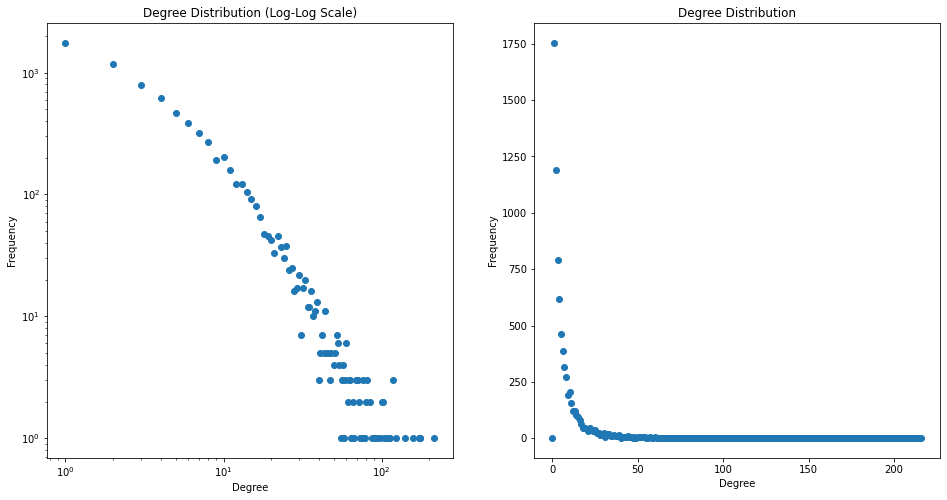


Grado promedio: 7.2943336831059815


In [127]:
deg_list = nx.degree_histogram(social_network)

plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 2)
plt.plot(range(len(deg_list)), deg_list, marker='o', linestyle='None')
plt.title('Degree Distribution')
plt.xlabel('Degree')
plt.ylabel('Frequency')

plt.subplot(1, 2, 1)
plt.loglog(range(len(deg_list)), deg_list, marker='o', linestyle='None')
plt.title('Degree Distribution (Log-Log Scale)')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.show()

avg_degree = np.mean([d for n, d in social_network.degree()])

print()
print('Grado promedio:', avg_degree)


A partir de los resultados obtenidos, se observa una curva que muestra que en este grafo en particular hay gran número de nodos con grados bajos y un número decreciente de nodos con grados más altos, con pocos nodos de grados muy altos (hubs). Dada la forma del grafico log se puede empezar a sospechar de una posible distribución o grafo scale-free tras un burner, se observa la existencia de hubs muy conectados, y se observa que el grado promedio de 7.29 no es suficiente para caracterizar el comportamiento complejo que muestra el grafo, aunque puede ser buen indicador de la proporción o la distribución que hay en este.

## 2.3 Detección de HUB (4 puntos)

Determine la existencia de HUB en la red, indicando los nodos. Justifique el criterio utilizado.

Luego, realice un gráfico apropiado que permita visualizarlos en la red (modificar tamaño o color).

**Respuesta:**

In [154]:
deg = sorted(social_network.degree(), key=lambda x: x[1], reverse=True)
deg[:32]

[('7237', 216),
 ('3530', 175),
 ('4785', 174),
 ('524', 172),
 ('3450', 159),
 ('2510', 140),
 ('3597', 124),
 ('2854', 119),
 ('6101', 119),
 ('5127', 119),
 ('4811', 113),
 ('5578', 108),
 ('1937', 106),
 ('290', 104),
 ('5274', 102),
 ('3240', 102),
 ('3544', 100),
 ('4900', 100),
 ('5854', 98),
 ('6519', 94),
 ('2083', 90),
 ('110', 89),
 ('763', 87),
 ('1005', 84),
 ('3038', 84),
 ('5857', 81),
 ('1792', 81),
 ('2892', 81),
 ('6446', 80),
 ('2798', 80),
 ('3103', 79),
 ('1677', 78)]

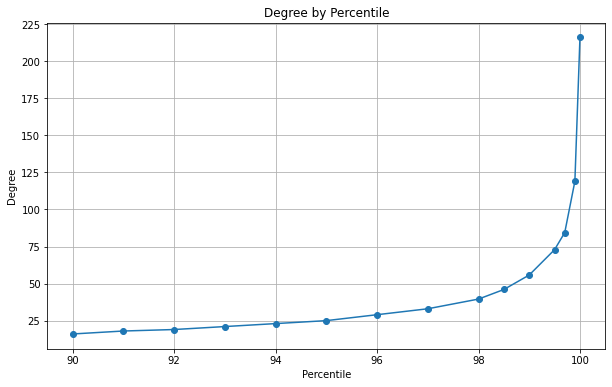

In [160]:
deg_list = [d for n, d in social_network.degree()]
percentile_list = [90, 91, 92, 93, 94, 95, 96, 97, 98, 98.5, 99, 99.5, 99.7, 99.9, 100]
deg_by_percentile = {p: np.percentile(deg_list, p) for p in percentile_list}

plt.figure(figsize=(10, 6))
plt.plot(list(deg_by_percentile.keys()), list(deg_by_percentile.values()), marker='o')
plt.title('Degree by Percentile')
plt.xlabel('Percentile')
plt.ylabel('Degree')
plt.grid()
plt.show()

In [161]:
np.percentile(deg_list, 99.5)

72.88500000000022

In [155]:
hubs_list = [n for n, d in social_network.degree() if d >= 72]
print(len(hubs_list))

41


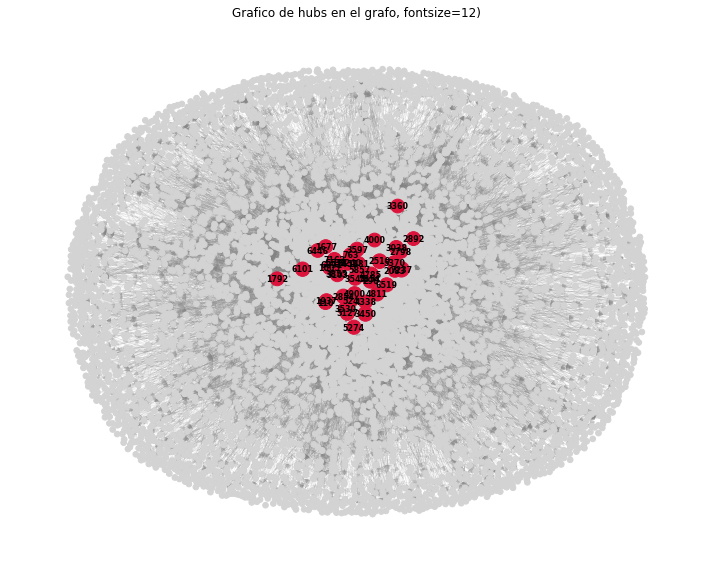

In [ ]:
deg_dict = dict(social_network.degree())

pos = nx.spring_layout(social_network, seed=3)

nonhubs = [n for n in social_network.nodes() if n not in hubs_list]

def size(n, hub=False):
    base = 30 if not hub else 120
    scale = 1.5 if not hub else 8
    return base + scale * np.sqrt(deg_dict[n])

sizes_non = [size(n, hub=False) for n in nonhubs]
sizes_hub = [size(n, hub=True) for n in hubs_list]

plt.figure(figsize=(10, 8))
nx.draw_networkx_edges(social_network, pos, alpha=0.15, width=0.5, edge_color="gray")

nx.draw_networkx_nodes(
    social_network, pos, nodelist=nonhubs, node_color="lightgray", node_size=sizes_non
)

nx.draw_networkx_nodes(
    social_network, pos, nodelist=hubs_list, node_color="crimson", node_size=sizes_hub
)

nx.draw_networkx_labels(
    social_network, pos, labels={n: str(n) for n in hubs_list}, font_size=8, font_weight="bold"
)

plt.title(f"Grafico de hubs en el grafo, fontsize=12)")
plt.axis("off")
plt.tight_layout()
plt.show()

# Plot apoyado por IA para que se vea mejor

Para detectar los hubs, utilicé el criterio de degree centrality, es decir, cuantas aristas tienen los nodos. Para encontrar los nodos los ordené por grado, grafiqué el grado según el percentil de nodo, y me quedé con los 41 nodos más grandes, con k > 72 según las estimaciones dadas por el grafico. Es una forma cruda, y se puede argumentar que hay nodos de otros percentiles que se pueden argumentar que son hubs, pero se están buscando los principales, y tanto el gráfico por percentiles como el grafico del grafo parecen apoyar esta como una elección defendible de hubs.

## 2.4 Scale-Free (4 puntos)

Calcule el coeficiente **gamma (γ)**, ajustando una power-law. Obtenga el coeficiente de determinación. ¿Qué tan bueno es el ajuste?

¿La red es scale-free? Justifique su respuesta.

**Respuesta:**

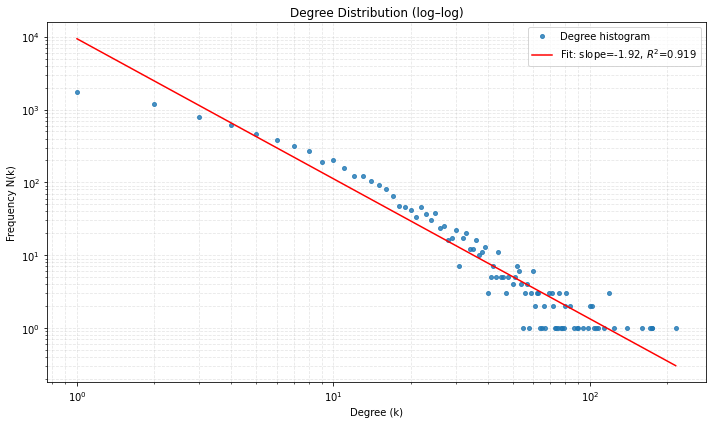

El exponente de la power law (γ): 1.9223698243519427
El R^2 del ajuste: 0.919058979666202
El p-value del ajuste: 3.3090913245353425e-54


In [ ]:

deg_hist = np.array(nx.degree_histogram(social_network))
k = np.arange(len(deg_hist))

# Aquí quitamos los 0's, pero es válido quemar el principio
# de la cola buscando power law.

mask = (k > 0) & (deg_hist > 0)
k_pos = k[mask].astype(float)
freq_pos = deg_hist[mask].astype(float)

logk = np.log(k_pos)
logf = np.log(freq_pos)
slope, intercept, r, p, se = stats.linregress(logk, logf)

k_line = np.logspace(np.log10(k_pos.min()), np.log10(k_pos.max()), 200)
fit_line = np.exp(intercept) * k_line**slope

plt.figure(figsize=(10, 6))
plt.loglog(k_pos, freq_pos, 'o', ms=4, alpha=0.8, label='Degree histogram')
plt.loglog(k_line, fit_line, '-', color='red',
           label=f'Fit: slope={slope:.2f}, $R^2$={r**2:.3f}')
plt.title('Degree Distribution (log–log)')
plt.xlabel('Degree (k)')
plt.ylabel('Frequency N(k)')
plt.grid(True, which='both', ls='--', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

print('El exponente de la power law (γ):', -slope)
print('El R^2 del ajuste:', r**2)
print('El p-value del ajuste:', p)

A partir de los experimentos se obtuvo un increíble ajuste, con un coeficiente de determianción $R^{2}$ aproximado de 0.92 y un p-value increíblemente significativo al ajuste. Sin embargo, a pesar de estos buenos resultados del ajuste, es dudoso si es que la distribución sigue una power-law (y es scale free) por el componente gamma = 1.92, dado que las redes scale-free tienden a seguir $2 < \gamma < 3$ para mantener las propiedades de la varianza infinita y de la esperanza $\neq$ cuando los nodos tienden a infinito. *Puede* ser que el ajute sea muy bueno, y un gamma muy cercano a 2, pero queda en duda si es que es o no es efectivamente scale-free y requiere de más tests para estar seguros.

## 2.5 Comparación de redes (4 puntos)

Utilizando las principales características de la red social analizada, cree dos grafos basados en los modelos Erdös-Rényi y Barabási-Albert.

* Para Erdös-Rényi: evalúe **p** en el intervalo 0 a p=0.001, seleccionando la probabilidad de tal manera que el grado promedio del grafo se aproxime al de la red social real.

* Para Barabási–Albert: evalúe **m** entre 1 y 20. Seleccione este parámetro de tal manera que el grado promedio del grafo creado se aproxime al de red social real.

Luego, en un mismo gráfico, muestre la distribución de grado de los tres grafos: red social real, Erdös-Rényi y Barabási–Albert. ¿Qué tipo de modelo de grafo se ajusta mejor al comportamiento de la red social? Justique.

**Respuesta:**

Para Erdos-Renyi, se busca que el grado promedio sea equivalente al grafo visto de la red social. Dado que el grado de cada nodo distribuye binomial(p, n-1), tenemos que $ \langle k \rangle = \mathbb{E}(k) = p(n-1)$.

De este modo, basta igualar el grado promedio del grafo original y resolver para p. Supondremos que tienen el mismo número de nodos.

In [214]:
average_degree = np.mean([d for n, d in social_network.degree()])
n_nodes = social_network.number_of_nodes()

p_erdos = average_degree / (n_nodes - 1)
p_erdos

0.0009568849118596329

Lo que nos da un p ligeramente menor al rango pedido, pero bastante cerca.

In [215]:
erdos_g = nx.erdos_renyi_graph(n_nodes, p_erdos)
erdos_avgdeg = np.mean([d for n, d in erdos_g.degree()])

In [216]:
disposable_list = np.linspace(1, 20, 20).astype(int)
for m in disposable_list:
    ba_g = nx.barabasi_albert_graph(n_nodes, m)
    avg_deg = np.mean([d for n, d in ba_g.degree()])
    print(f'm = {m}, avg degree = {avg_deg}')
    if avg_deg >= average_degree:
        break

m = 1, avg degree = 1.9997376705141658
m = 2, avg degree = 3.9989506820566634
m = 3, avg degree = 5.997639034627492
m = 4, avg degree = 7.995802728226653


Nos quedamos con m = 4

In [218]:
ba_g = nx.barabasi_albert_graph(n_nodes, 4)
bag_g_avg_deg = np.mean([d for n, d in ba_g.degree()])

In [219]:
print('Los avg degrees son:')
print(f'Social Network: {average_degree}')
print(f'Erdos-Renyi Graph: {erdos_avgdeg}')
print(f'Barabasi-Albert Graph: {bag_g_avg_deg}')

Los avg degrees son:
Social Network: 7.2943336831059815
Erdos-Renyi Graph: 7.307712486883526
Barabasi-Albert Graph: 7.995802728226653


In [220]:
def plot_deg_distribution(g, title="Degree Distribution"):
    deg_hist = np.array(nx.degree_histogram(g))
    k = np.arange(len(deg_hist))

    mask = (k > 0) & (deg_hist > 0)
    k_pos = k[mask].astype(float)
    freq_pos = deg_hist[mask].astype(float)

    logk = np.log(k_pos)
    logf = np.log(freq_pos)
    slope, intercept, r, p, se = stats.linregress(logk, logf)

    k_line = np.logspace(np.log10(k_pos.min()), np.log10(k_pos.max()), 200)
    fit_line = np.exp(intercept) * k_line**slope

    plt.figure(figsize=(10, 6))
    plt.loglog(k_pos, freq_pos, 'o', ms=4, alpha=0.8, label='Degree histogram')
    plt.loglog(k_line, fit_line, '-', color='red',
               label=f'Fit: slope={slope:.2f}, $R^2$={r**2:.3f}')
    plt.title(title)
    plt.xlabel('Degree (k)')
    plt.ylabel('Frequency N(k)')
    plt.grid(True, which='both', ls='--', alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

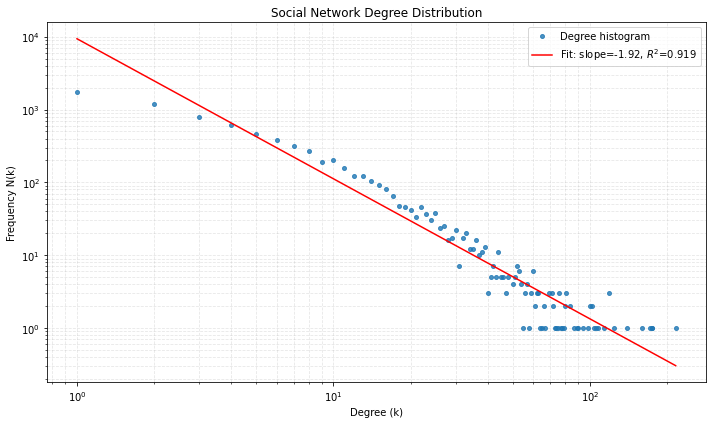

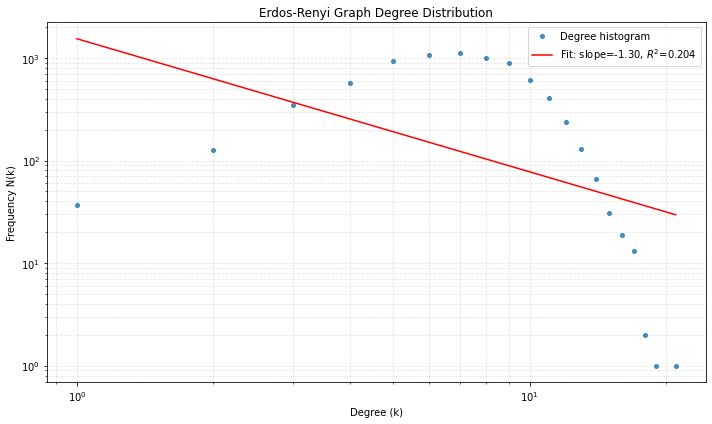

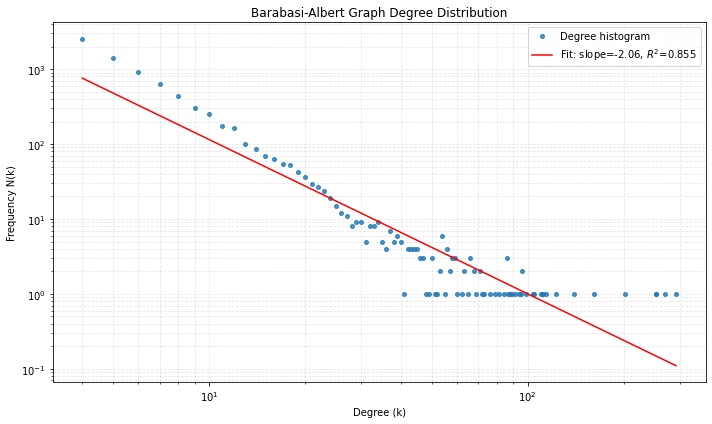

In [221]:
plot_deg_distribution(social_network, title="Social Network Degree Distribution")
plot_deg_distribution(erdos_g, title="Erdos-Renyi Graph Degree Distribution")
plot_deg_distribution(ba_g, title="Barabasi-Albert Graph Degree Distribution")

Claramente, el modelo que mejor se ajusta a la distribución de grado de la red social es el modelo Barabasi-Albert. Esto se debe a que la red de la red social tiene un cierto grado de estructura, hubs de distintos tamaños, y una distribución de grado que los modelos Erdos sencillamente no tienen y que el modelo Barabasi-Albert, al poder generar grafos scale-free, puede seguir.

# Parte 3: Detección de comunidades (20 puntos)

En esta sección investigaremos e implementaremos métodos de detección de comunidades. Esta tarea resulta fundamental, ya que permite comprender cómo se organizan los nodos de un grafo en grupos con alta cohesión interna

## 3.1 Definiciones (2.5 Puntos)

Investigue y defina los siguientes conceptos relacionados con detección de comunidades en grafos:
* Algoritmo de Louvain
* Algoritmo de Leiden
* Modularidad
* Normalized Mutual Information (NMI)
* Adjusted Rand Index (ARI)

**Respuesta:**

El problema de detección de comunidades en grafos es una tarea funcamental dentro de área, y existe una amplia literatura y recursos para estudiarlo. A continuación se muestran algunos de los principales conceptos.

1. Modularidad

    Modularidad es una metrica, que mide que tan fuertemente clusterizados se encuentran las estructuras de un grafo dado. Más modularidad se refiere a conexiones más densas dentro de un cluster y más sparse con aquellas fueras del cluster dado. Notar que la métrica se mueve entre los valores [-1/2, 1]

    Para calcularlo, se mide el número de aritas que caen dentro de los grupos determinados menos el valor esperado de si las aristas fuesen calculadas de manera aleatoria.

2. Normalized Mutual Information (NMI)

    NMI es una metrica basada en teoría de información que busca medir cuanta información comparten dos particiones de los mismos nodos (notar que esta métrica utiliza nodos). Para esto, calcula las probabilidades, la información mutua, la entropía, y finalmente normaliza la entropia para que se puedan comparar particiones con distinto número de comunidades. Notar que esta métrica va en [0, 1], con 0 representando independencia y 1 dependencia total. Un detalle adicional es que esta metrica tiende a producir errores cuando el número de comunidades aumentar bastante (https://www.nature.com/articles/s41598-024-59073-9).

3. Adjusted Rand Index (ARI)

    ARI es una metrica que busca medir que tanto se parecen dos particiones de nodos en conjuntos, asignandole un valor entre -1 y 1. En esta metrica, 1 significa similitud exacta y -1 disimilitud exacta. Para calcularala, se comparan cuántos pares de nodos fueron clasificados de la misma manera en ambas particiones.

4. Algoritmo de Louvain

    Es un algoritmo heuristico greedy propuesto el año 2008 que busca encontrar comunidades en un grafo a través de la maximización de la modularidad. El algortimo se puede describir como:

    1. Cada nodo comienza siendo una comunidad de 1, y se itera nodo a nodo viendo si unirlo a la comunidad de algún vecino o no, dependiendo de si aumenta la modularidad. Se realiza esto iterativamente hasta que no se pueda aumentar más la modularidad.

    2. Se genera un grafo más pequño en donde cada comunidad detectada se vuelve un nodo, con las nuevas aristas teniendo el peso acumulado de las aristas anteriores hacia las otras comunidades.

    3. Volver a 1 o stop según criterio.

5. Algoritmo de Leiden

    El algoritmo de Leiden una mejora del algoritmo de Louvain, propuesto el año 2019, que busca mejorar las falencias que este tiene, principalmente lo que sucede con comunidades mal conectadas y problemas de resolución (ignorar comunidades pequeñas y fusionarlas con grandes).

    Para esto, el algoritmo sigue la siguiente estructura:

    1. Se mueve cada nodo de comunidad en comunidad buscando aumentar la modularidad.

    2. En vez de colapsar las comunidades en nodos inmediatamente (como en Louvain), se subdividen las comunidades mal conectadas en partes más pequeñas, garantizando que cada mini-componente sea conexa en si. Esta es la etapa que hace la mayor diferencia con el algoritmo anterior. Se asegura que las comunidades pequeñas sigan existiendo y que las comunidades queden bien conectadas (en subconjuntos conexos).

    3. Se construye el grafo reducido como en Louvain.

    4. Volver a 1 o stop según criterio.

## 3.2 Modelo LFR (2.5 Puntos)

Cree un grafo usando el modelo Lancichinetti-Fortunato-Radicchi con los siguientes hiperparámetros:

* n = 300
* tau1 = 3
* tau2 = 1.5
* mu = 0.2
* average_degree = 7
* min_community = 20
* seed = 10

¿Cuántas nodos, aristas y comunidades tiene el grafo?

**Respuesta:**

In [1]:
from cdlib import evaluation, algorithms, benchmark

Note: to be able to use all crisp methods, you need to install some additional packages:  {'graph_tool'}


In [3]:
# lfr = nx.LFR_benchmark_graph(
#     n=300,
#     tau1=3,
#     tau2=1.5,
#     mu=0.2,
#     average_degree=7,
#     min_community=20,
#     seed=10
# )

lfr, coms = benchmark.LFR(n=300,
                        tau1=3,
                        tau2=1.5,
                        mu=0.2,
                        average_degree=7,
                        min_community=20,
                        seed=10)

In [4]:
print('Numero de nodos:', lfr.number_of_nodes())
print('Numero de aristas:', lfr.number_of_edges())
print('Numero de comunidades:', len(coms.communities))

Numero de nodos: 300
Numero de aristas: 1015
Numero de comunidades: 10


## 3.3 Implementación de algoritmos (5 Puntos)

Aplique los algoritmos de Louvain y Leiden al grafo obtenido en la sección anterior, y obtenga la partición de comunidades resultante de cada algoritmo.

*Nota:* Puede usar librerias externas que ya implementen estos algoritmos.

**Respuesta:**

In [5]:
b = time.time()
louvain_communities_results = algorithms.louvain(lfr)
a = time.time()
print('Louvain listo en:', a-b, 'segundos')


b = time.time()
leiden_communities_results = algorithms.leiden(lfr)
a = time.time()
print('Leiden listo en: ', a-b, 'segundos' )

Louvain listo en: 0.03647208213806152 segundos
Leiden listo en:  0.0260469913482666 segundos


## 3.4 Medición de la calidad de las comunidades (5 Puntos)

Calcule las métricas NMI y ARI para las particiones obtenidas por cada algoritmo. Comente sus resultados.

**Respuesta:**

In [8]:
nmi_gt_leiden  = evaluation.normalized_mutual_information(coms, leiden_communities_results).score
nmi_gt_louvain = evaluation.normalized_mutual_information(coms, louvain_communities_results).score

ari_gt_leiden  = evaluation.adjusted_rand_index(coms, leiden_communities_results).score
ari_gt_louvain = evaluation.adjusted_rand_index(coms, louvain_communities_results).score

nmi_lv_ld  = evaluation.normalized_mutual_information(louvain_communities_results, leiden_communities_results).score
ari_lv_ld  = evaluation.adjusted_rand_index(louvain_communities_results,  leiden_communities_results).score

In [15]:

print("NMI(GT, Leiden)",  round(nmi_gt_leiden, 4))
print("NMI(GT, Louvain)", round(nmi_gt_louvain, 4))
print("ARI(GT, Leiden)",  round(ari_gt_leiden, 4))
print("ARI(GT, Louvain)", round(ari_gt_louvain, 4))
print("NMI(Louvain, Leiden)", round(nmi_lv_ld, 4))
print("ARI(Louvain, Leiden)", round(ari_lv_ld, 4))


NMI(GT, Leiden) 0.8972
NMI(GT, Louvain) 0.8514
ARI(GT, Leiden) 0.8691
ARI(GT, Louvain) 0.8182
NMI(Louvain, Leiden) 0.9195
ARI(Louvain, Leiden) 0.901


| Comparación       | NMI    | ARI    |
| ----------------- | ------ | ------ |
| GT vs Leiden      | 0.8972 | 0.8691 |
| GT vs Louvain     | 0.8514 | 0.8182 |
| Louvain vs Leiden | 0.9195 | 0.9010 |


A partir de los experimentos se destaca que los dos algoritmos, Louvain y Leiden, lograron rescatar bien las comunidades del modelo benchmark Lancichinetti-Fortunato-Radicchi, ya sea en la composición de las comunidades por nodos (ARI) o de la información prevista por el clustering (NMI), puesto que ambos valores se encuentran cerca de 1. Se destaca además que el algoritmo de Leiden logró ser dar mejores resultados en ambas metricas que el de Loivain, y a menor tiempo para este caso pequeño, respaldando la literatura. (https://leidenalg.readthedocs.io/en/stable/intro.html). Como consecuencia de esto, ambas particiones fueron bastante similares entre si. Finalmente, se deja como comentario que es interasante notar que estos algoritmos funcionan intentando maximizar la modularidad, una metrica principalmente de edges, y sin embargo, logran dar excelentes resultados en otras métricas basadas en el labeling de los nodos para este benchmark case, mostrando como se pueden relacionan estas metricas.

## 3.5 Detección y representación de comunidades (5 Puntos)

Ejecute los algoritmos sobre alguno de los grafos de las secciones anteriores. Grafique el grafo coloreando los nodos según la partición obtenida y comente.

**Respuesta:**

Se elige ejecutar el algoritmo sobre el grafo social de la parte 2 (versión no dirigida).

In [18]:
with open('/Users/vittoriosalvatore/local_desk/Universidad/aprendizaje_en_grafos/Tarea_1/lastfm_asia_edges.csv', 'r') as f:
    next(f)
    social_network = nx.read_edgelist(
    f,
    delimiter=',')
social_network.number_of_nodes()

7624

In [20]:
social_louvain_results = algorithms.louvain(social_network)
social_leiden_results = algorithms.leiden(social_network)

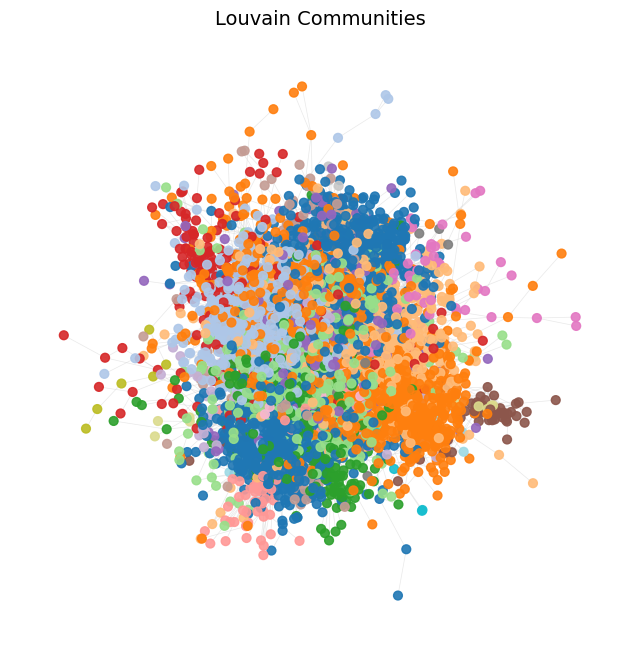

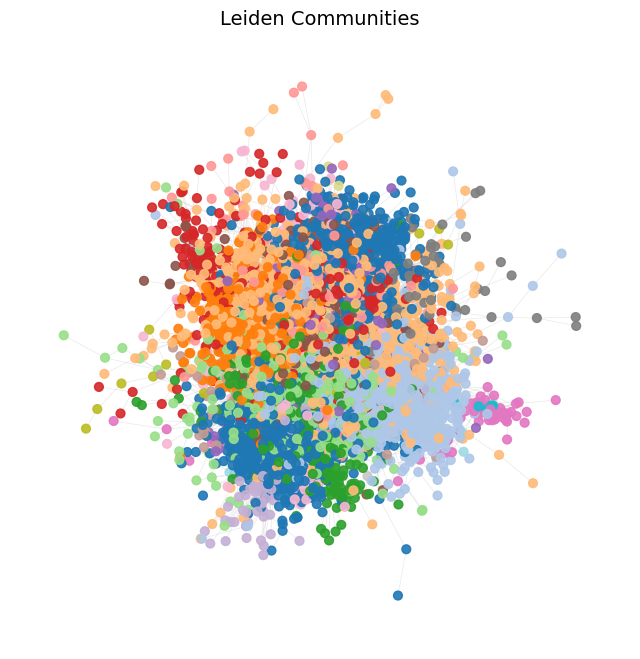

In [ ]:
def plot_partition(graph, clustering, title="Communities"):

    partition = {}
    for cid, comm in enumerate(clustering.communities):
        for node in comm:
            partition[node] = cid
    
    pos = nx.spring_layout(graph, seed=10, k=0.15)

    node_colors = [partition[n] for n in graph.nodes()]

    plt.figure(figsize=(8, 8))
    nx.draw_networkx_nodes(
        graph, pos,
        node_color=node_colors,
        cmap=plt.cm.tab20,
        node_size=40,        # smaller nodes
        alpha=0.9
    )
    nx.draw_networkx_edges(
        graph, pos,
        edge_color="lightgray",
        width=0.5,
        alpha=0.5
    )
    plt.title(title, fontsize=14)
    plt.axis("off")
    plt.show()

plot_partition(social_network, social_louvain_results, "Louvain Communities")
plot_partition(social_network, social_leiden_results, "Leiden Communities")


Ambos algoritmos logran separar la red social en distintas comunidades, como se esperaría que estas existiesen en una red social. Esto se ve en que grandes áreas muy cercanas y conectadas, y sus extensiones en las periferias del grafo se colorean del mismo color. En cuanto a ambos métodos, se nota que ambos logran generar una estructura similar, con los mismos clusters grandes coloreados. Sin embargo, el algoritmo de Leiden parece captar mejor comunidades más pequeñas, principalmente en la cantidad de categorias distintas que hay en el medio del grafo y en las periferias que están más cohesionados que en Louvain. Sin embargo, para un grafo de este tamaño, y con la estructura que uno esperaría de una red social, las diferencias no parecen ser significativas desde un punto de vista visual, y sería necesario grafos más complejos o con menos estructura para verdaderamente visualizar la diferencia entre ambos métodos.